In [27]:
import torch
import math
from ksddescent import ksdd_lbfgs, ksdd_gradient
from ksddescent.contenders import svgd, mmd_lbfgs
import matplotlib.pyplot as plt
import numpy as np

from ksd_descent_gaussian import ksdd_lbfgs_gaussian


In [28]:
# GMM target
def make_mog(centers, vars, weights):
    weights = torch.tensor(weights)
    weights /= weights.sum()

    def score(x):
        den = 0
        top = 0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            den += weight * exp
            top += weight * exp[:, None] * (x - center) / var
        return -top / den[:, None]

    def potential(x):
        op = 0.0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            op += weight * exp
        return torch.log(op)

    def sampler(n_samples):
        x = []
        for c, v, w in zip(centers, vars, weights):
            z = torch.randn(int(n_samples * w), 2)
            z *= np.sqrt(v)
            z += c
            x.append(z.clone())
        return torch.cat(x)

    return score, potential, sampler

In [29]:
# settings of the experiment
var = 1.0
centers = [
    torch.tensor([-2.05, -4.95]),
    torch.tensor([4.02, 1.98]),
    # torch.tensor([0.97, -1.03]),
]
variances = [var, var]
weights = [0.5, 0.5]

score, potential, sampler = make_mog(centers, variances, weights)

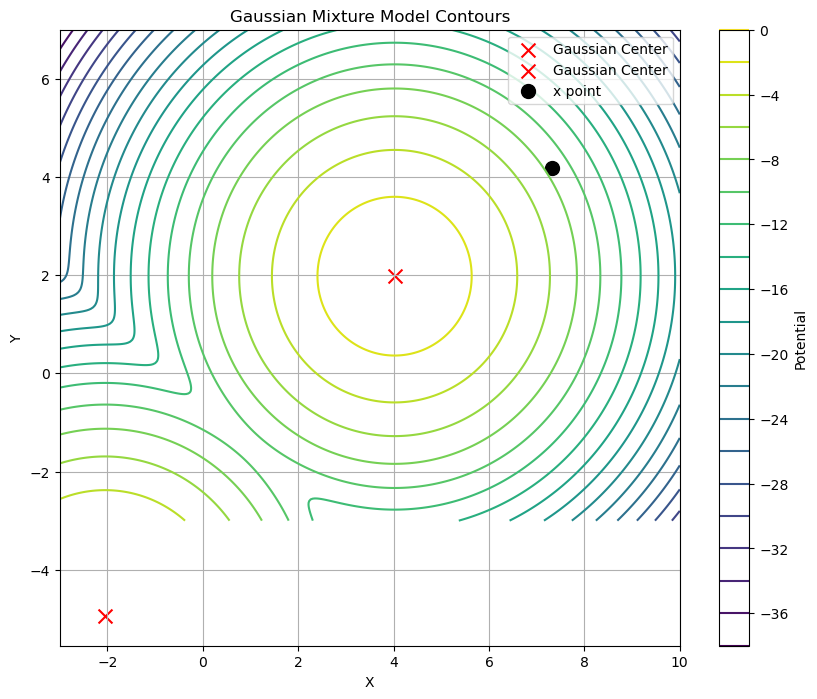

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points
x_range = np.linspace(-3, 10, 300)
y_range = np.linspace(-3, 7, 300)
X, Y = np.meshgrid(x_range, y_range)

# Evaluate the potential function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32)
        Z[i, j] = potential(point).item()

# Create the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Potential')

# Plot the centers of the Gaussians
for center in centers:
    plt.scatter(center[0].item(), center[1].item(), color='red', s=100, marker='x', label='Gaussian Center')

# Plot the x point
x = torch.tensor([[7.3198, 4.1910]], requires_grad=True)
plt.scatter(x[0, 0].detach().numpy(), x[0, 1].detach().numpy(), color='black', s=100, marker='o', label='x point')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Mixture Model Contours')
plt.legend()
plt.grid(True)
plt.show()



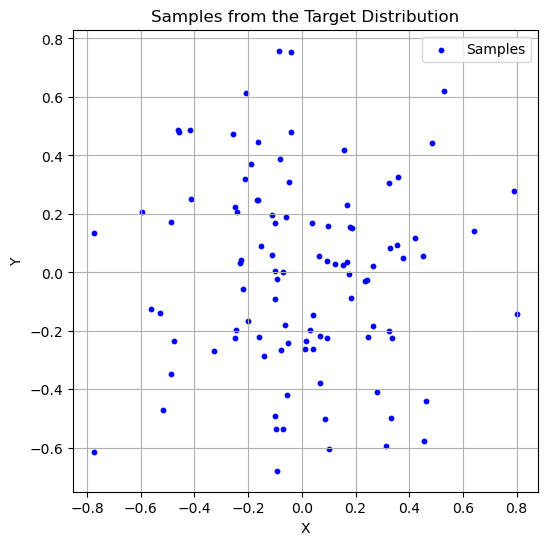

In [31]:
# some random samples as initials
x = torch.randn(n_samples, p) / 3
# plot the samples
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], color='blue', s=10, label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from the Target Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# calculate the mean and cholesky factor of the covariance of those samples. use them to set m0, L0
# Calculate the mean and covariance of the samples
m0 = torch.mean(x, dim=0)
cov = torch.cov(x.T)

# Compute the Cholesky decomposition of the covariance matrix
L0 = torch.linalg.cholesky(cov)

# previou hand set initial
# m0 = torch.tensor([-5, 6.1])  # mean
# L0 = torch.tensor([[1.2, 0.1], [0.4, 0.4]])  # lower triangular matrix for covariance

Initial mean (m0): tensor([-0.0060, -0.0062])
Initial Cholesky factor (L0):
 tensor([[ 0.3116,  0.0000],
        [-0.0099,  0.3247]])


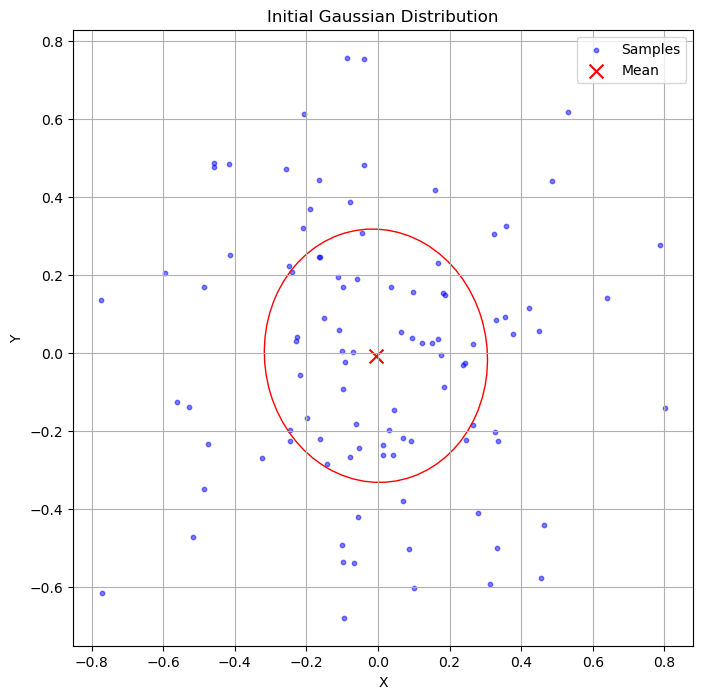

In [33]:

print("Initial mean (m0):", m0)
print("Initial Cholesky factor (L0):\n", L0)

# Visualize the initial Gaussian distribution
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:, 1], color='blue', s=10, alpha=0.5, label='Samples')
plt.scatter(m0[0], m0[1], color='red', s=100, marker='x', label='Mean')

# Plot the covariance ellipse
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
angle = torch.atan2(eigenvectors[1, 0], eigenvectors[0, 0]).item()
width, height = 2 * torch.sqrt(eigenvalues)
from matplotlib.patches import Ellipse

ellipse = Ellipse(xy=(m0[0].item(), m0[1].item()), width=width.item(), height=height.item(),
                  angle=np.degrees(angle), facecolor='none', edgecolor='red')
plt.gca().add_patch(ellipse)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Initial Gaussian Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
n_samples = 100 # affects how many samples in the reparameterization trick
p = 2 # dimension

# aneal the temperature
beta = 0.05
def score_beta(x):
    return beta * score(x)



bw = 0.1 # bandwidth of the kernel

# call the Gaussian KSD descent
# m_ksd, L_ksd, m_traj, L_traj, _ = ksdd_lbfgs_gaussian(m0.clone(), L0.clone(), n_samples, score, bw=bw, store=True, verbose=True)

# call the Gaussian KSD descent with temperature
m_ksd, L_ksd, m_traj, L_traj, _ = ksdd_lbfgs_gaussian(m0.clone(), L0.clone(), n_samples, score_beta, bw=bw, store=True, verbose=True)


Took 0.03 sec, 3 iterations, loss = 2.34e-01


# Plots

In [35]:
# # Visualize the Gaussian distribution defined by m_ksd and L_ksd

# # Generate a grid of points
# x_ = np.linspace(-1.2, 1.2, 100)
# y_ = np.linspace(-1.2, 1.2, 100)
# X, Y = np.meshgrid(x_, y_)
# XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

# # Compute the Gaussian density
# cov_ksd = torch.matmul(L_ksd, L_ksd.T)
# inv_cov_ksd = torch.inverse(cov_ksd)
# diff = XX - m_ksd
# exponent = -0.5 * torch.sum(diff @ inv_cov_ksd * diff, dim=1)
# Z = torch.exp(exponent).reshape(X.shape).detach().numpy()

# # Plot the Gaussian density
# plt.figure(figsize=(6, 6))
# plt.contourf(X, Y, Z, levels=20, cmap="viridis")
# plt.colorbar(label="Density")
# plt.scatter(m_ksd[0], m_ksd[1], color="red", label="Mean (m_ksd)")
# plt.title("Final Gaussian Distribution with KSD-optimized Parameters")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.legend()
# plt.show()



In [36]:
# # make another plot. this time, we plot the contour of the Gaussian within one standard deviation
# # Plot the contour of the Gaussian within one standard deviation
# plt.figure(figsize=(6, 6))
# # plt.contourf(X, Y, Z, levels=20, cmap="viridis")
# # plt.colorbar(label="Density")
# plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label="1 Std Dev Contour")
# plt.scatter(m_ksd[0], m_ksd[1], color="red", label="Mean (m_ksd)")
# plt.title("Final Gaussian Distribution with KSD-optimized Parameters (1 Std Dev Contour)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.legend()
# plt.show()


# Now, let's plot the trajectories

In [37]:
# Check the length of m_traj and L_traj
print("Length of m_traj:", len(m_traj))
print("Length of L_traj:", len(L_traj))


Length of m_traj: 3
Length of L_traj: 3


In [38]:
# Print the content of m_traj
for i, m in enumerate(m_traj):
    print(f"Iteration {i}: m = {m}")


Iteration 0: m = tensor([0.0033, 0.0041])
Iteration 1: m = tensor([0.0033, 0.0041])
Iteration 2: m = tensor([0.0033, 0.0041])


In [39]:
# why is only three iterations recorded?

/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_18388/298487539.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")
/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_18388/298487539.py:35: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(X, Y, Z_target, levels=10, colors="k", linestyle="solid", linewidths=1)
/var/folders/f6/8vzd7z213t58mr4nsz9bys0w0000gn/T/ipykernel_18388/298487539.py:36: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="k", linestyle="solid", linewidths=2, label="Target 1 Std Dev Contour")


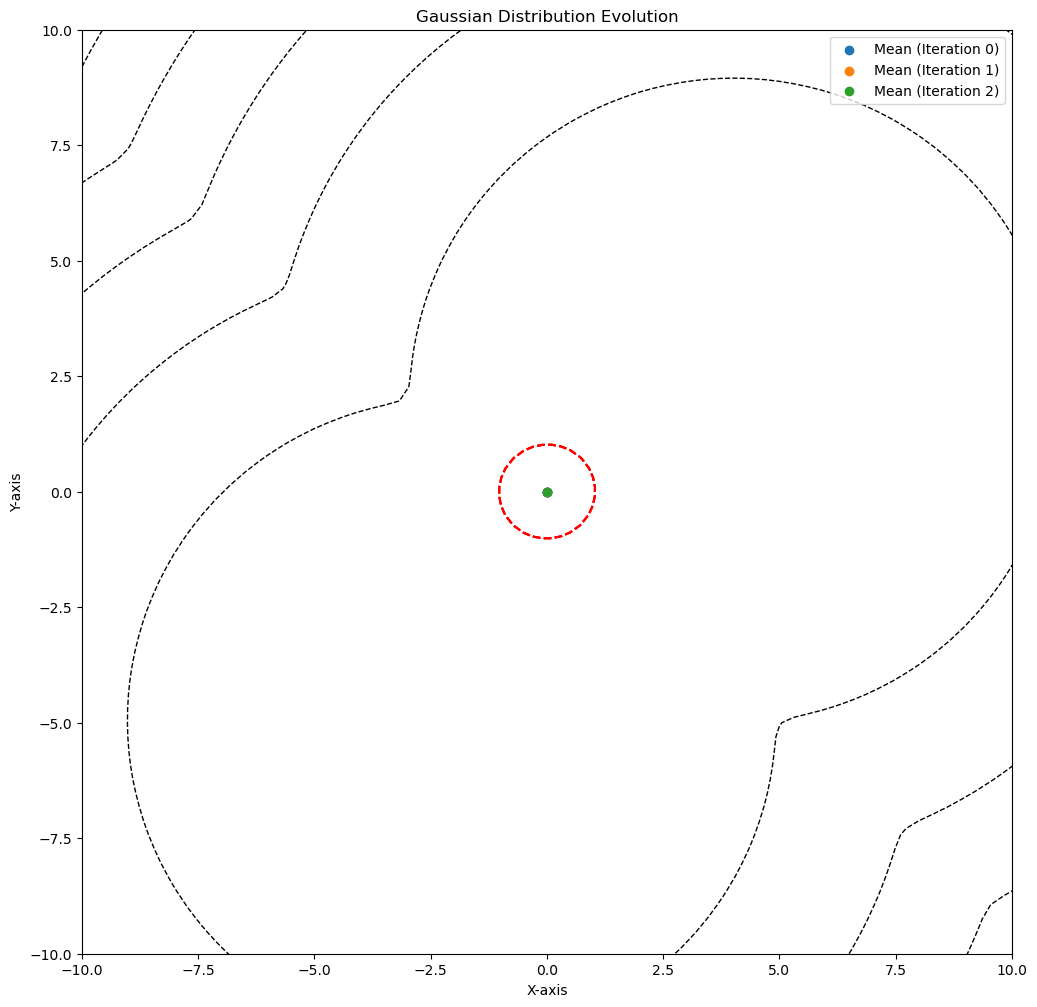

In [40]:
# Plot the evolution of the Gaussian distributions using the mean and Cholesky factor of covariance stored in the lists m_traj, L_traj

plt.figure(figsize=(12, 12))  # Make the plot figure size larger

# Extract the means from m_traj for plotting the trajectory
means = np.array([m.detach().numpy() for m in m_traj])

# Create a grid of points for plotting the Gaussian density
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XX = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)

for i, (m, L) in enumerate(zip(m_traj, L_traj)):
    # Compute the Gaussian density for the current mean and covariance
    cov = torch.matmul(L, L.T)
    inv_cov = torch.inverse(cov)
    diff = XX - m
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim=1)
    Z = torch.exp(exponent).reshape(X.shape).detach().numpy()
    
    # Plot only one contour line
    plt.contour(X, Y, Z, levels=[np.exp(-0.5)], colors="red", linestyles="dashed", label=f"1 Std Dev Contour (Iteration {i})")
    plt.scatter(m[0], m[1], label=f"Mean (Iteration {i})")

# Plot the trajectory line connecting the means
plt.plot(means[:, 0], means[:, 1], color="blue", linestyle="-", marker="o", alpha=0.5, zorder=0)


# Plot the target density contour
x_ = np.linspace(-15, 15, 100)
y_ = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x_, y_)
XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
Z_target = potential(XX).reshape(X.shape).detach().numpy()

plt.contour(X, Y, Z_target, levels=10, colors="k", linestyle="solid", linewidths=1)
plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="k", linestyle="solid", linewidths=2, label="Target 1 Std Dev Contour")


plt.title("Gaussian Distribution Evolution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(-10, 10)  # Set x limits larger to show all plots
plt.ylim(-10, 10)  # Set y limits larger to show all plots
plt.legend()
plt.show()


TODO: use the potential function, plot the target Gaussian density

In [41]:
# Get the target Gaussian distribution information from the sampler function
target_mean = torch.zeros(2)
target_cov = 0.3 * torch.eye(2)
target_inv_cov = torch.inverse(target_cov)

# Compute the Gaussian density for the target distribution
diff = XX - target_mean
exponent = -0.5 * torch.sum(diff @ target_inv_cov * diff, dim=1)
Z_target = torch.exp(exponent).reshape(X.shape).detach().numpy()

# Plot the target distribution with a solid black contour
plt.contour(X, Y, Z_target, levels=[np.exp(-0.5)], colors="black", linewidths=2, label="1 Std Dev Contour (True Distribution)")

# Add a scatter point for the target mean
plt.scatter(target_mean[0], target_mean[1], color="black", s=100, label="True Mean")

plt.legend()
plt.show()


RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

# plot the performance metric
we use the reverse KL, ie
$$
\mathcal{D}_{KL}( \pi | \hat \mu_t ) = \int \pi(x) \log \frac{\pi(x)}{\hat \mu_t(x)} dx
$$
where $\pi$ is the target distribution, and $\hat \mu_t$ is the distribution following our inference trajectory at time $t$.

## Non-Gaussian target
- [ ] In this case, is it possible to use the potential to evaluate the performance metric?